<a href="https://colab.research.google.com/github/anslemhuncho/MACHINE-LEARNING-PROJECT/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 2684 images belonging to 10 classes.
Found 2684 images belonging to 10 classes.
58889256/58889256 [==============================] - 0s 0us/step


Epoch 1/10
84/84 [==============================] - 593s 7s/step - loss: 2.0821 - accuracy: 0.2221 - precision: 0.3177 - recall: 0.0227 - val_loss: 1.7893 - val_accuracy: 0.3342 - val_precision: 0.9275 - val_recall: 0.0238
Epoch 2/10
84/84 [==============================] - 54s 646ms/step - loss: 1.8658 - accuracy: 0.2750 - precision: 0.6045 - recall: 0.0302 - val_loss: 1.6241 - val_accuracy: 0.4080 - val_precision: 0.9610 - val_recall: 0.0276
Epoch 3/10
84/84 [==============================] - 54s 650ms/step - loss: 1.7457 - accuracy: 0.3182 - precision: 0.6727 - recall: 0.0689 - val_loss: 1.5711 - val_accuracy: 0.4311 - val_precision: 0.8588 - val_recall: 0.0816
Epoch 4/10
84/84 [==============================] - 54s 643ms/step - loss: 1.7202 - accuracy: 0.3349 - precision: 0.6269 - recall: 0.0782 - val_loss: 1.5167 - val_accuracy: 0.4706 - val_precision: 0.9302 - val_recall: 0.0745
Epoch 5/10
84/84 [==============================] - 54s 645ms/step - loss: 1.6641 - accuracy: 0.3547 -

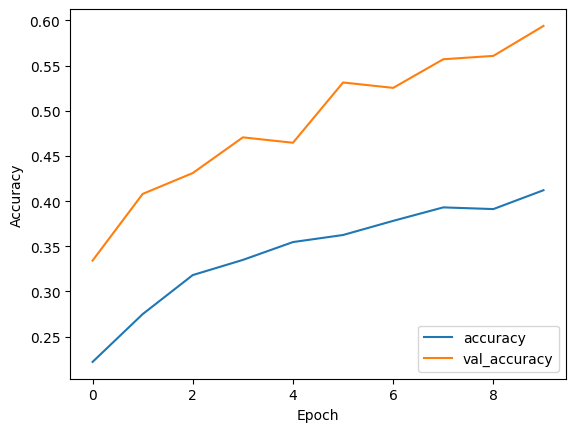

In [ ]:


# Define paths to your train and test folders in Google Drive
train_path = '/content/drive/MyDrive/normalised data'
test_path = '/content/drive/MyDrive/normalised data'

# Manually specify class labels and their indices
class_labels = {
    0: 'animals_protection',
    1: 'appealing_for_peace',
    2: 'brexit',
    3: 'covid19',
    4: 'election',
    5: 'environment_protection',
    6: 'gender_equality',
    7: 'immigration',
    8: 'racial_equality',
    9: 'yellow_vests_movement'
}

# Create ImageDataGenerator for data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Adjust batch size based on your system's memory
batch_size = 32  # Experiment with different batch sizes
target_size = (150, 150)  # Reduce image size for faster processing

# Generate batches of augmented data from train and test folders
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_labels.values(),
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_labels.values(),
    shuffle=False
)

# Define the ANN model architecture on top of VGG16 base model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_labels), activation='softmax')
])

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with additional metrics
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

# Train the model with increased steps per epoch for faster iterations
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)

# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import numpy as np

# Make predictions on the test data
predictions = model.predict(test_generator)

# Get the predicted class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get the true class labels
true_classes = test_generator.classes

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Print some example predictions
for i in range(10):  # Print predictions for the first 10 samples
    print(f"Sample {i+1}: Predicted Class: {class_labels[predicted_classes[i]]}, True Class: {class_labels[true_classes[i]]}")


84/84 [==============================] - 23s 276ms/step
Sample 1: Predicted Class: animals_protection, True Class: animals_protection
Sample 2: Predicted Class: appealing_for_peace, True Class: animals_protection
Sample 3: Predicted Class: animals_protection, True Class: animals_protection
Sample 4: Predicted Class: animals_protection, True Class: animals_protection
Sample 5: Predicted Class: appealing_for_peace, True Class: animals_protection
Sample 6: Predicted Class: yellow_vests_movement, True Class: animals_protection
Sample 7: Predicted Class: appealing_for_peace, True Class: animals_protection
Sample 8: Predicted Class: appealing_for_peace, True Class: animals_protection
Sample 9: Predicted Class: appealing_for_peace, True Class: animals_protection
Sample 10: Predicted Class: animals_protection, True Class: animals_protection
